# Notes:

- Double clicking a code cell will reveal the Python code.
- Users signed in with a Google account will be able to run the code. This seems to be necessary in order to display and interact with the graphcis widget.
- Google Colab limits its users' ability to use standard parallelization tools. In real-world applications, it would be easy to substantially speed up both the plotting and permutation test using the module Multiprocessing.

# Setup; only need to run these cells once.

In [ ]:
#@title Import packages; set Seaborn defaults; download data.
import sys
import itertools

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn import preprocessing

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook",
  rc={"font.size":12, "font.family":"sans-serif", 
      # "font.serif":"P052", # note: kills the original list font.serif
      "axes.titlesize":"medium", "axes.titlepad":20, 
      # "axes.titleweight":"medium",
      # "axes.labelsize":"normal", 
      "axes.labelpad":10, 
      "axes.labelweight":"regular",  # lighter is not actually an option
      "xtick.labelsize":"small", "ytick.labelsize":"small", 
      #  "axes.facecolor":"white", # vertical axis padding is weird with this
      # "legend.fontsize": "large", 
      "legend.title_fontsize":"large",
      "xtick.major.width":3, "ytick.major.width":3,
      "legend.loc":"lower right", 
      "figure.dpi":80, "figure.titlesize":"large", 
      "figure.titleweight":"bold"
  }
)
# context: "notebook"
from google.colab import widgets


data_url = "https://github.com/codygunton/NBA-Shooter-Profiler/raw/master/data/shot_logs_prepped.csv"
! test -f shot_logs_prepped.csv || wget {data_url}
df = pd.read_csv("shot_logs_prepped.csv")

In [2]:
#@title Functions for selecting and standardizing variables.

def get_cluster_vars(use_DRIBBLES=True):
  cluster_vars = ["SHOT_CLOCK", "DRIBBLES", "TOUCH_TIME", "SHOT_DIST"]
  if not use_DRIBBLES:
    cluster_vars.remove("DRIBBLES")
  return cluster_vars

def get_standardized_player_df(pf, cluster_vars):
  stzd_cluster_vars = pd.DataFrame(preprocessing.scale(pf[cluster_vars]), 
                                  columns=cluster_vars, index=pf.index)
  d = dict([[c, stzd_cluster_vars[c]] for c in cluster_vars])
  pf_stzd = pf.assign(**d)
  return pf_stzd

In [3]:
#@title Functions for setting axis limits of pairplot on per-player basis.

# We will produce a grid of plots using seaborn.pairplot. The natural limits
# for the internal plots are not ideal for our purposes, so we set the limits
# manually on a per-player basis. This allows us, for instance, to better 
# visualize the shot profiles of "bigs" who rarely shoot far from the basket,
# and who tend to take fewer dribbles.

def set_per_player_lims(pf, cluster_vars, g): # g is a seaborn.axisgrid.PairGrid
  # get [min, max] range for each variable
  # TODO: keep 1 or two standard deviations from the mean.

  cluster_var_lims = list(map(lambda v: [pf[str(v)].min(), pf[str(v)].max()], 
                              cluster_vars))

  # Add a little padding to axis limis to make the plots look nicer
  ep = .6
  cluster_var_lims = list(map(lambda L: [L[0]-ep, np.round(L[1]+ep,2)], 
                              cluster_var_lims))


  # Now we will get x limits and y limits that will work for every
  # possible pairgrid.
  prod_lims = list(itertools.product(cluster_var_lims, repeat=2))
  prod_names = list(itertools.product(cluster_vars, repeat=2))

  # to agree with the arrangement of plots in the PairGrid, should swap each pair
  swap = lambda L: L[::-1]
  prod_lims = list(map(swap, prod_lims))
  prod_names = list(map(swap, prod_names))

  # now get 2-d array of tuples of xlims
  xlims = np.empty(len(cluster_vars)**2, dtype=object)
  xlims[:] = [tuple(t[0]) for t in prod_lims]
  xlims = xlims.reshape((len(cluster_vars),len(cluster_vars)))

  # now get 2-d array of tuples of ylims
  ylims = np.empty(len(cluster_vars)**2, dtype=object)
  ylims[:] = [tuple(t[1]) for t in prod_lims]
  ylims = ylims.reshape((len(cluster_vars),len(cluster_vars)))


  # Define functions for setting axes within grid.
  def safe_set_xlim(xlim, ax):
      if ax is None:
          pass
      else:
          ax.set_xlim(xlim)

  def safe_set_ylim(ylim, ax):
      if ax is None:
          pass
      else:
          ax.set_ylim(ylim)


  vec_safe_set_xlim = np.vectorize(safe_set_xlim)
  vec_safe_set_ylim = np.vectorize(safe_set_ylim)

  vec_safe_set_xlim(xlims, g.axes)
  vec_safe_set_ylim(ylims, g.axes)

In [4]:
#@title Function for making pairplots.

def make_corner_plot(g):
  """The default behavior of sns.pairplot, when corner=True, is to
  delete the axis label, ticks, etc for the upper left plot.
  This function avoids that. Note: the Seaborn source code notes
  that the implementation of the corner option is similarly obtuse.
  It would be straightforward to improve this for speed, but one 
  would have to write a custom pairplot function."""

  num_vars = g.axes.shape[0]
  hide_pairs = itertools.product(range(num_vars), repeat=2)
  hide_pairs = [(i,j) for i,j in hide_pairs if i < j]
  [g.axes[i,j].remove() for i,j in hide_pairs]



def get_all_clusters_pairplot(df, cluster_vars, labels, name="all", 
                              set_lims=True, use_kde=True):
  """Produce Seaborn pairplots of all of the cluster variables,
  coloring by cluster label."""
  plot_df = df[cluster_vars].assign(CLUSTER=labels)
  # Note: there is a known issue with KDE estimating bandwidth to 0.
  # It can be resolved by manually setting bw, e.g., by passing 
  # diag_kws={'bw':0.1}, but that results in ugly plots sometimes.
  if use_kde:
    g = sns.pairplot(plot_df, hue="CLUSTER")

  else:
    g = sns.pairplot(plot_df, hue="CLUSTER", 
                     diag_kind="hist",
                     diag_kws={"histtype":"step",
                               "density":True})

  if set_lims:
    set_per_player_lims(pf, cluster_vars, g)
  make_corner_plot(g)

  def plot_title(awl):
    if name in ["a", "all"]:
      return "All Games"
    elif name in ["w", "wins"]:
      return "Wins"
    elif name in ["l", "losses"]:
      return "Losses"
    else:
      raise ValueError

  # delete meaningless tickmarks
  g.axes[0,0].set_yticklabels([""])

  # plot title
  ax = g.axes[0,-1]
  bbox = ax.get_position()
  x,y = bbox.corners()[3]
  g.fig.suptitle(f"{player_name.title()} | Profile in {plot_title(name)}", 
                x=x, y=y+.06, ha="right",
                fontsize="xx-large")

  # legend
  leg = g._legend
  leg.set_title("Cluster", prop={"size":"large", "weight":"bold"})
  leg.texts[0].set_weight("bold")
  ax = g.axes[0,-1]
  bbox = ax.get_position()
  x,y = bbox.corners()[3]
  leg.set_bbox_to_anchor((x,y-.08))
  leg.set_frame_on(True)

  # reformat legend, adding shot counts
  legend_dict = dict(kmeans_labels[0].value_counts())
  for i in legend_dict:
    legend_dict[i] = f"{i} ({legend_dict[i]} shots)"
  for t in g._legend.texts:
    idx = int(t.get_text())
    t.set_text(legend_dict[idx])
  return g



def get_one_cluster_pairplot(df, cluster_vars, labels, i, set_lims=True, use_kde=True):
  plot_df = df[labels[0]==i]
  plot_df = plot_df[cluster_vars+["W"]]

  ith_color = np.array(sns.color_palette()[i])
  palette = {"W":ith_color, "L":np.repeat(0.4, 3)}


  # Note: there is a known issue with KDE estimating bandwidth to 0.
  # It can be resolved by manually setting bw, e.g., by passing 
  # diag_kws={'bw':0.1}, but that results in ugly plots sometimes.
  if use_kde:
    g = sns.pairplot(plot_df, hue="W", 
                     palette=palette)
    
  else:
    g = sns.pairplot(plot_df, hue="W", 
                     palette=palette, 
                     diag_kind="hist",
                     diag_kws={"histtype":"step",
                               "density":True})
  if set_lims:
    set_per_player_lims(pf, cluster_vars, g)
  make_corner_plot(g)

  # delete meaningless tickmarks
  g.axes[0,0].set_yticklabels([])

  # plot title
  ax = g.axes[0,-1]
  bbox = ax.get_position()
  x,y = bbox.corners()[3]
  g.fig.suptitle(f"{player_name.title()} | Cluster Number: {i}", 
                x=x, y=y+.06, ha="right",
                fontsize="xx-large")

  # legend
  leg = g._legend
  leg.set_title("Outcome", prop={"size":"large", "weight":"bold"})
  leg.texts[0].set_weight("bold")
  ax = g.axes[0,-1]
  bbox = ax.get_position()
  x,y = bbox.corners()[3]
  leg.set_bbox_to_anchor((x,y-.04))
  leg.set_frame_on(True)

  # reformat legend, adding shot counts
  legend_dict = dict(plot_df.W.value_counts())
  for x in legend_dict:
    legend_dict[x] = f"{x} ({legend_dict[x]} shots)"
  for t in g._legend.texts:
    idx = t.get_text()
    t.set_text(legend_dict[idx])
  return g



# g = get_all_clusters_pairplot(pf, cluster_vars, kmeans_labels)
# get_one_cluster_pairplot(pf, cluster_vars, kmeans_labels, i=0)

# Choose a player to profile and build data frames

In [5]:
#@title Select player; select variables for clustering; copy and standardize data frame.

# # to make a drop-down of player names in Colab, we need to 
# # produce a list of all player names and then paste in below.
# L = list(df.player_name.unique())
# L = list(map(lambda s: "\""+s+"\"", L))
# L.sort()
# print("[" + ", ".join(L) + "]")

player_name = "james harden" 
pf = df[df.player_name == player_name]
AWL_dict = {"all" : pf,
            "wins" : pf[pf.W=="W"],
            "losses" : pf[pf.W=="L"]}

# get variables for clustering (3 or 4 depending on whether to use DRIBBLES)
use_DRIBBLES = True #@param {type:"boolean"}
cluster_vars = get_cluster_vars(use_DRIBBLES=use_DRIBBLES)
print("Variable to be kept for clustering are: "+", ".join(cluster_vars)+".")
pf_stzd = get_standardized_player_df(pf, cluster_vars)

pf

Variable to be kept for clustering are: SHOT_CLOCK, DRIBBLES, TOUCH_TIME, SHOT_DIST.


,GAME_ID,W,SHOT_CLOCK,GAME_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,player_name
90424,21400901,L,20.1,476,0,2.4,3.6,james harden
90425,21400901,L,16.0,393,1,1.4,25.0,james harden
90426,21400901,L,16.7,372,0,1.1,24.4,james harden
90427,21400901,L,13.9,271,2,3.8,7.7,james harden
90428,21400901,L,1.5,6,24,22.6,20.7,james harden
...,...,...,...,...,...,...,...,...
91463,21400003,W,2.0,2,1,1.8,3.9,james harden
91464,21400003,W,6.9,441,0,0.4,19.6,james harden
91465,21400003,W,18.4,369,1,0.8,23.5,james harden
91466,21400003,W,16.3,157,6,6.1,5.8,james harden


# k-Means Clustering and Visualization

The value of our the clustering analysis here will lie in the user's ability to give a practical interpretation of the clusters. For instance, the user might see that, for a particular value of k, all of a players catch-and-shoot 3's lie in a single cluster. It is advisable for the user to try a few values of k, inspecting the plot each time to search for an interpretation of each cluster.


To assist in the search for k, we provide two validation metrics: the Davies-Bouldin index and the average silhouette score. Computing all values of the metrics for k from 2 to 6 is quick, we suggest to calculate all values and then consider any value of k between the two scores.

In [6]:
#@title Compare Davies–Bouldin indices (small values are better)
def kmeans_with_DBI(df_stzd, cluster_vars, print_table=False):
  """For k from 2 to 6, calculate the D-B index. Use this to 
  choose the best value of k, run k-means, and return labels."""
  best_k = None
  best_labels = None
  out_df = pd.DataFrame([], columns = ["DBI"]).rename_axis("k")

  for k in range(2,7):
    clustering = KMeans(n_clusters=k,
                        random_state=1).fit(df_stzd[cluster_vars])
    kmeans_labels = CLUSTER_kmeans=clustering.labels_

    dbi = metrics.davies_bouldin_score(df_stzd[cluster_vars], kmeans_labels)
    out_df.loc[k] = dbi
    if k==2 or dbi < best_dbi:
      best_k = k
      best_dbi = dbi
      best_labels = kmeans_labels
  
  if print_table:
    print(out_df.T)

  kmeans_labels = pd.DataFrame(best_labels, index=df_stzd.index)
  kmeans_labels.algorithm = "k-means" 
  return best_k, kmeans_labels

best_k, _ = kmeans_with_DBI(pf_stzd, cluster_vars, print_table=True)
print(f"Best k is {best_k}.")

k           2         3         4         5         6
DBI  1.098061  1.036862  0.955384  0.983828  0.986502
Best k is 4.


In [7]:
#@title Compare silhouette scores (larger values are better)
def kmeans_with_silhouette(df_stzd, cluster_vars, print_table=False):
  """For k from 2 to 6, calculate the average silhouette score index. 
  Use this to choose the best value of k, run k-means, and return labels."""

  best_k = None
  best_labels = None
  out_df = pd.DataFrame([], columns = ["Silhouette Score"]).rename_axis("k")

  for k in range(2,7):
    clustering = KMeans(n_clusters=k,
                        random_state=1).fit(df_stzd[cluster_vars])
    kmeans_labels = CLUSTER_kmeans=clustering.labels_

    score = metrics.silhouette_score(df_stzd[cluster_vars], kmeans_labels)
    out_df.loc[k] = score
    if k==2 or score > best_score:
      best_k = k
      best_score = score
      best_labels = kmeans_labels
  
  if print_table:
    print(out_df.T)

  kmeans_labels = pd.DataFrame(best_labels, index=df_stzd.index)
  kmeans_labels.algorithm = "k-means" 
  return best_k, kmeans_labels

best_k, _ = kmeans_with_silhouette(pf_stzd, cluster_vars, print_table=True)
print(f"Best k is {best_k}.")

k                        2         3         4         5         6
Silhouette Score  0.369282  0.369971  0.382391  0.375963  0.369569
Best k is 4.


Fit k-means with k = 4.


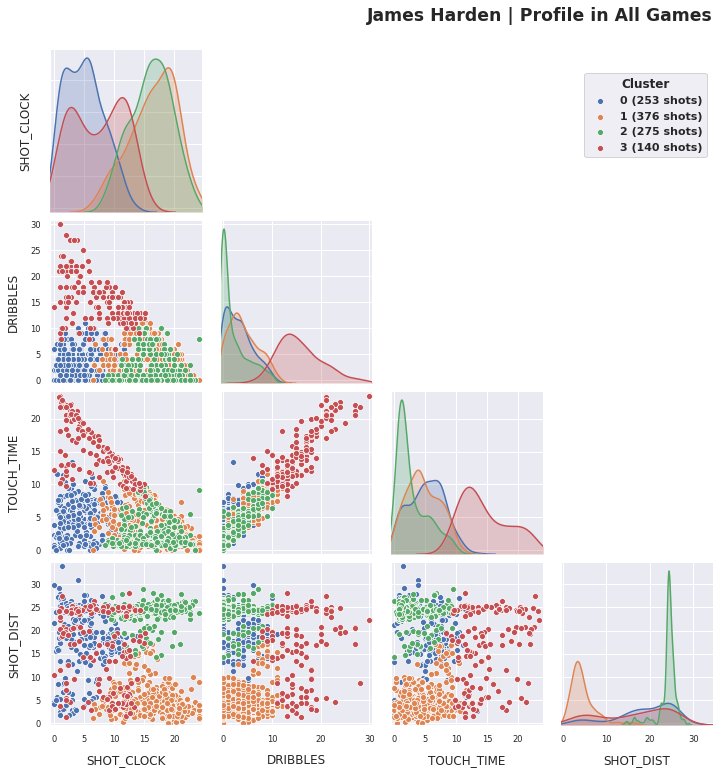

In [8]:
#@title k-means; choose k, or specify a metric for choosing k.

def get_kmeans_labels(k, df_stzd, cluster_vars):
  """Run k-means for a manual choice of k."""
  clustering = KMeans(n_clusters=k, random_state=1).fit(df_stzd[cluster_vars])
  out_df = pd.DataFrame(clustering.labels_, index=df_stzd.index)
  out_df.algorithm = "k-means"
  return out_df

k = "Silhouette score" #@param["Davies-Bouldin", "Silhouette score", 2,3,4,5,6]
if k == "Davies-Bouldin":
  k, kmeans_labels = kmeans_with_DBI(pf_stzd, cluster_vars)
elif k == "Silhouette score":
  k, kmeans_labels = kmeans_with_silhouette(pf_stzd, cluster_vars)
else:
  k = int(k)
  kmeans_labels = get_kmeans_labels(k, pf_stzd, cluster_vars)

print(f"Fit k-means with k = {k}.")

show_plot = True #@param {type:"boolean"}

if show_plot:
  get_all_clusters_pairplot(pf,
                            cluster_vars, 
                            kmeans_labels, 
                            name="all")

Github doesn't render my Google Colab widget well, so I just list all of the plots here.


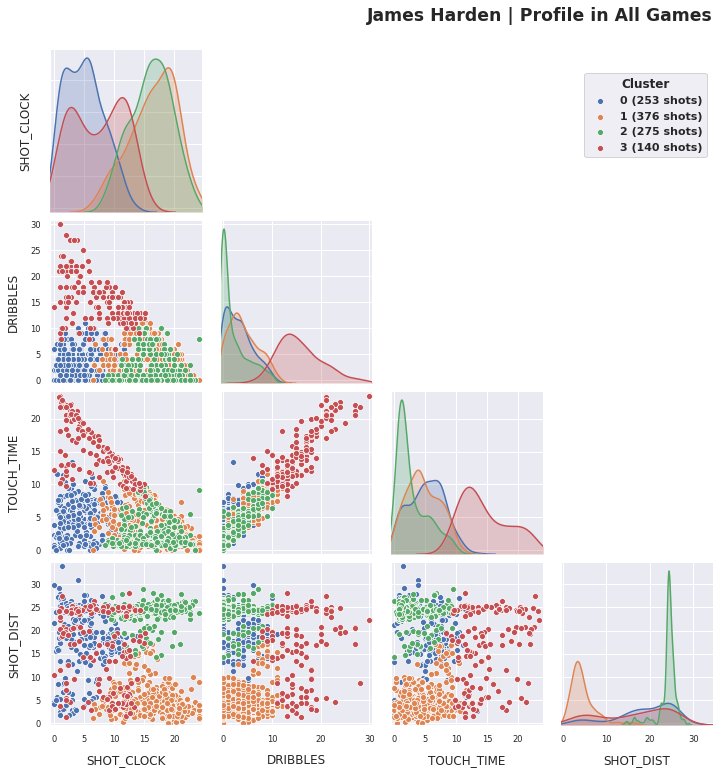

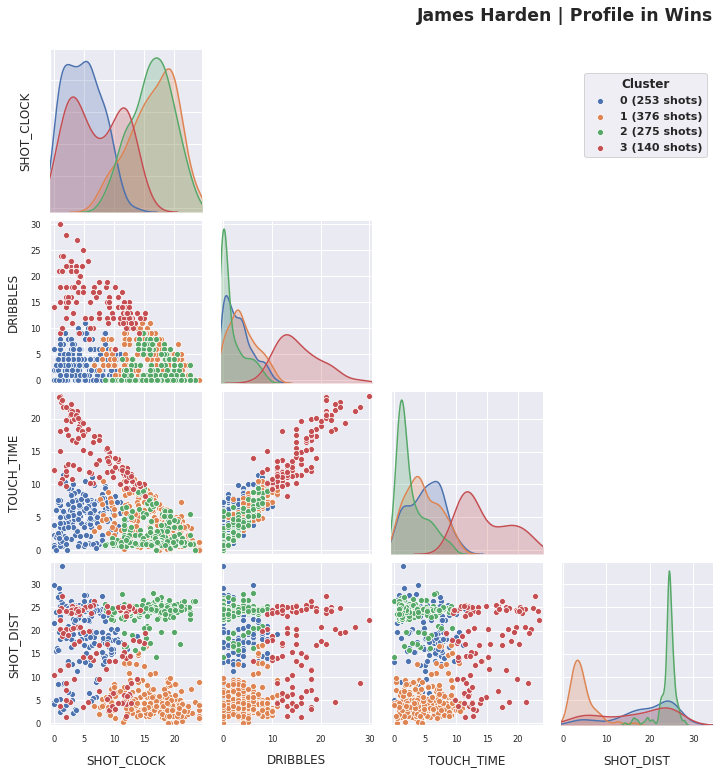

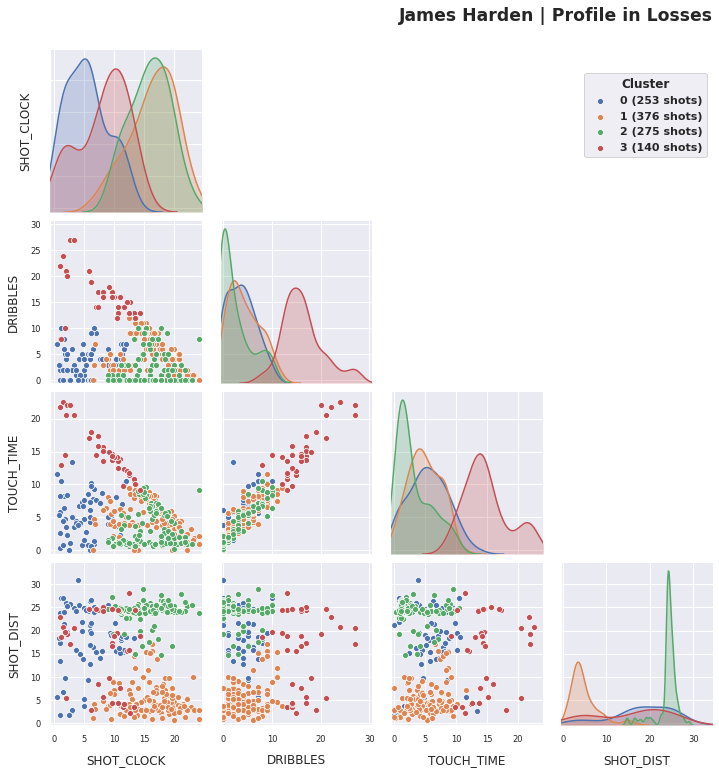

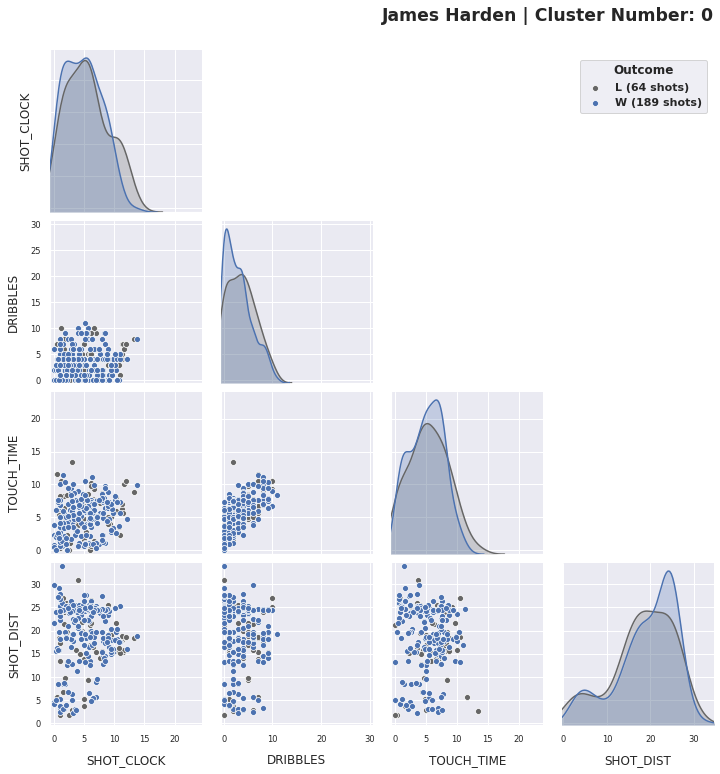

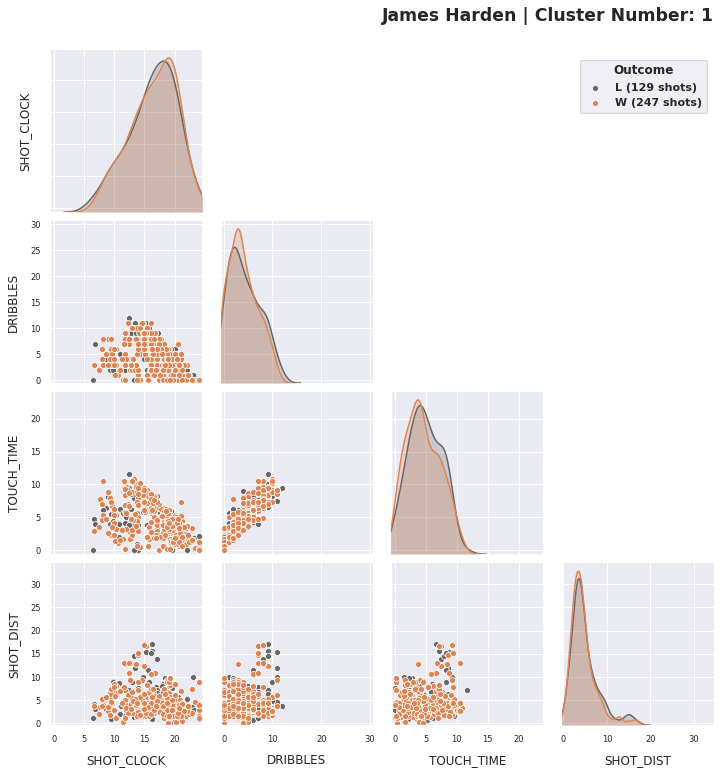

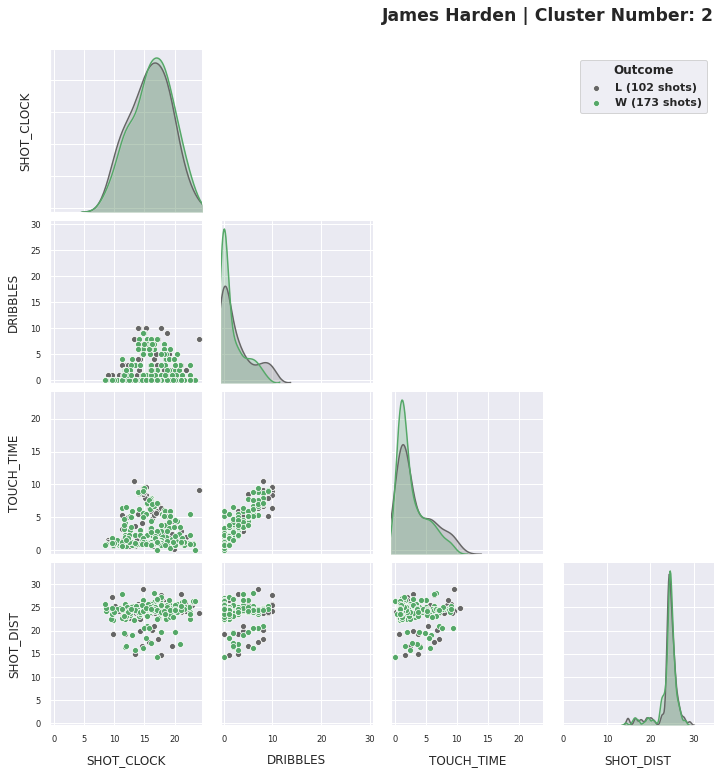

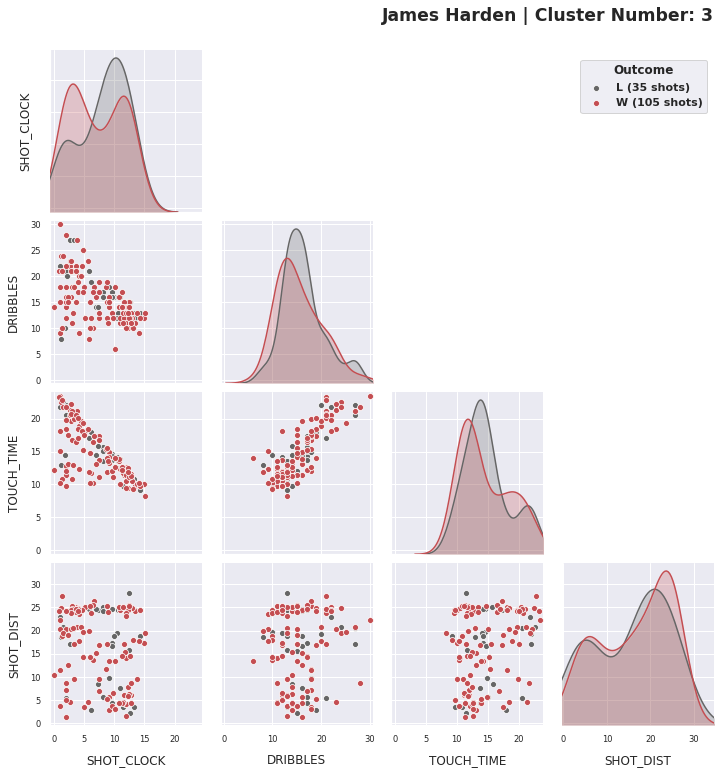

In [9]:
#@title Produce plots of the player's shot profile. Several different views can be accessed using the tabs at the top of the cell output. All clusters can be shown simultaneously in all games, or selecting only wins or losses. For each cluster, there is also a plot available for visualizing the change in the distrubtion in wins vs in losses.

show_plots = True #@param {type:"boolean"}
# KDE occsionally fails or produces weird plots; might want to disable,
# especially for players who play close to the basket.
use_kernel_density_estimation = True #@param {type:"boolean"}
use_kde = use_kernel_density_estimation
if show_plots:
  cluster_labels = pd.Series(kmeans_labels[0]).unique()
  cluster_labels.sort()

  # # This doesn't display well in Github.
  # tab_names = list(AWL_dict.keys()) + list(map(str, cluster_labels))
  # tb = widgets.TabBar(tab_names)
  # for name in AWL_dict:
  #   with tb.output_to(name):
  #     get_all_clusters_pairplot(AWL_dict[name],
  #                               cluster_vars, 
  #                               kmeans_labels, 
  #                               name=name,
  #                               use_kde=use_kde)

  # for i in cluster_labels:
  #   with tb.output_to(str(i)):
  #     get_one_cluster_pairplot(pf, cluster_vars, 
  #                             kmeans_labels, i=i,
  #                               use_kde=use_kde)

  print("Github doesn't render my Google Colab widget well,",
        "so I just list all of the plots here.")
  for name in AWL_dict:
    get_all_clusters_pairplot(AWL_dict[name],
                              cluster_vars, 
                              kmeans_labels, 
                              name=name,
                              use_kde=use_kde)

  for i in cluster_labels:
    get_one_cluster_pairplot(pf, cluster_vars, 
                            kmeans_labels, i=i,
                              use_kde=use_kde)



## Significance testing clusters in wins vs losses using R.

In [10]:
#@title Install R packages "Hotelling" and "Binom".
%%capture
# capturing long output showing installation progress of R package

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# install package for computing Hotelling T^2 statistic
if not rpackages.isinstalled("Hotelling"):
  utils.install_packages("Hotelling")
importr("Hotelling")

# install package for computing binomial confidence intervals
if not rpackages.isinstalled("binom"):
  utils.install_packages("binom")
importr("binom")

In [11]:
#@title Implement Python wrappers for computing Hotelling statistic and computing binomial confidence intervals; define function for significance test of one cluster; define function for performing multiple significance tests. Suggested usage is to examine the plots above to interpret the clusters, then to find a single cluster which seems to vary in wins or losses, then to check significance of that single cluster. We suggest starting with 1000, and running again with 10,000 or more if additional precision is required.

def T2(wins, losses):
  """A Python wrapper for computing the Hotelling stastic using the
  R funtion hotelling.stat.
  Inputs: two pandas dataframes, the partition of a single cluster
          into shots in wins vs shots in losses."""
  with localconverter(ro.default_converter + pandas2ri.converter):
      r_wins   = ro.conversion.py2rpy(wins)
      r_losses = ro.conversion.py2rpy(losses)
      # should find better way to unpack; float() doesn't work
  r_T2 = ro.r["hotelling.stat"]
  T2_val = list(r_T2(r_wins, r_losses)[0])[0]
  return T2_val


def get_stat_and_sample(pf, labels, i, num_perms):
  """Compute the data for conducting a permutation test. Specifically, given a 
  player's dataframe and a dataframe of labels obtained by clustering, 
  compute the test statistic for the i-th cluster, along with num_perms-many 
  values of the Hotelling statistic for random partitions of the i-th cluster 
  into two pieces of sizes (num_wins, num_losses)."""

  pf = pf[labels[0]==i]
  wins   = pf[pf.W=="W"][cluster_vars]
  losses = pf[pf.W=="L"][cluster_vars]
  test_stat = T2(wins, losses)

  sample = [] # should pool.map this
  for n in range(num_perms):
      both = np.concatenate([wins, losses])
      both = np.random.permutation(both)
      # T2 needs a pandas df; no numpy arrays allowed
      vir_wins, vir_losses = map(pd.DataFrame, np.split(both, [len(wins)]))
      sample += [T2(vir_wins, vir_losses)]
  sample = pd.Series(sample)
  return test_stat, sample


def get_phat_and_interval(test_stat, sample, alpha_CI=0.01):
  """Using the R package Binom, calculate a confidence interval for the p-value 
  we estimated by estimating the permultation distribution for the Hotelling 
  statistic of a given cluster."""
  r_binconf = ro.r["binom.confint"]
  successes = sum(sample>=test_stat)
  num_trials = sample.shape[0]
  _, _, _, phat, lower, upper = r_binconf(successes, num_trials, alpha_CI, 
                                          method="exact")
  phat, lower, upper = tuple(np.round((phat[0], lower[0], upper[0]), 5))
  return phat, lower, upper


def perm_test_one_cluster(pf, labels, i=0, num_perms=1000, 
                          alpha_test=0.05, alpha_CI = 0.01, verbose=True):
  """Conduct a one-sided permututation test of the statement that there is a 
  significant difference in the i-th cluster between wins vs losses."""

  if verbose:
    print(f"Performing significance test with alpha = {alpha_test}.")

  player_name = pf.iloc[0].player_name.title()

  test_stat, sample = get_stat_and_sample(pf, labels, i, num_perms)
  phat, lower, upper = get_phat_and_interval(test_stat, sample, alpha_CI)

  if verbose:
    print(f"Cluster {i} has estimated p-value: {phat}.")
    print(f"A {int((1-alpha_CI)*100)}% confidence interval for this",
          f"p-value is ({lower}, {upper}).")
    g = sns.distplot(sample)
    title  = ("Test statistic and estimated permutation distribution ", 
              f"for Cluster {i}.\n", f"(Player: {player_name}; ", 
              f"algorithm: {labels.algorithm})")
    g.set_title("".join(title), {"horizontalalignment":"center"})
    ylims = g.get_ylim()
    plt.plot([test_stat,test_stat], ylims, color="red")
    g.set_ylim(ylims)
    _ = g.set_yticklabels([])

  return phat, lower, upper


def perm_test_all_clusters(pf, labels, num_perms=1000, alpha=0.05):
  """For each cluster, conduct a one-sided permututation test of the statement 
  that there is a significant difference between wins vs losses. We handle
  multiple comparisons using the Bonferroni correction."""
  print(f"Setting alpha = {alpha}.")
  num_clusters = labels[0].nunique()
  phats_and_lims = {}
  sig_vals = {}

  for i in range(num_clusters):
    phat, lower, upper = perm_test_one_cluster(pf, kmeans_labels, i, num_perms,
                                               alpha, verbose=False)
    phats_and_lims[i] = (phat, lower, upper)

  for i, t in phats_and_lims.items():
    if t[0] < alpha/num_clusters:  # Bonferroni correction used here. 
      sig_vals[i] = t

  if not sig_vals:
    print(f"No significant differences were found.")
  else:
    for i, t in sig_vals.items():
      phat, lower, upper = t
      s = (f"The partition of cluster {i} is significant with estimated ",
           f"p-value {phat}. A confidence interval for this estimated p-value " 
           f"is ({lower}, {upper}).")
      print("".join(s))

Performing significance test with alpha = 0.05.
Cluster 0 has estimated p-value: 0.2.
A 99% confidence interval for this p-value is (0.19944, 0.20076).
CPU times: user 13.2 s, sys: 9.52 s, total: 22.8 s
Wall time: 11.6 s


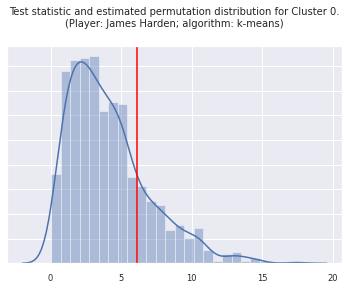

In [12]:
%%time
_ = perm_test_one_cluster(pf, kmeans_labels, i=0, num_perms=1000)

In [ ]:
%%time
# This has turned out to be less useful.
# Run a significance test of all clusters, correcting for multiple
# comparisons using the Bonferroni method.
perm_test_all_clusters(pf, kmeans_labels, num_perms=1000, alpha=0.5)

# Experimental: deep clustering with N2D.


Deep learning has provided new approached clustering, typically centered on the use of autoencoders for dimensionality reduction. I tried out one promising new algorithm called N2D. In the examples I ran, the method peformed worse than k-means, frequently identifying a large cluster which I believe plays the role of a sort of 'catch-all'. This may well use due to poor training (perhaps an appropriate early-stopping mechanism would make a big difference). However, given the much greater cost of N2D and the relative success of k-means, I would not spend too long trying to get N2D to work well.

In [ ]:
try:
  import n2d
except ImportError as e:
  ! pip install n2d
  import n2d

data_dir = "/content/drive/My Drive/data/nba-shots/"
n2d_weights_dir = data_dir + "n2d-weights/"
from tensorflow.io.gfile import makedirs, listdir
makedirs(n2d_weights_dir)
n2d_weights_path = (n2d_weights_dir
                   + player_name.replace(" ", "-") 
                   + "-n2dweights.h5")

In [15]:
def get_n2d_labels(num_clusters, df_stzd, cluster_vars):
  X = pf_stzd[cluster_vars].to_numpy()
  ae = n2d.AutoEncoder(X.shape[-1], latent_dim=num_clusters)
  manifoldGMM = n2d.UmapGMM(num_clusters)
  harcluster = n2d.n2d(ae, manifoldGMM)
  harcluster.fit(X, weight_id=n2d_weights_path)

  n2d_labels = harcluster.predict(X)
  out_df = pd.DataFrame(n2d_labels, index=df_stzd.index)
  out_df.algorithm = "n2d"
  return out_df

In [16]:
%%time
%%capture
# note: on a CPU, this will take several minutes.
n2d_labels = get_n2d_labels(k, pf_stzd, cluster_vars)

CPU times: user 28.5 s, sys: 4.58 s, total: 33 s
Wall time: 1min 6s


Github doesn't render my Google Colab widget well, so I just list all of the plots here.


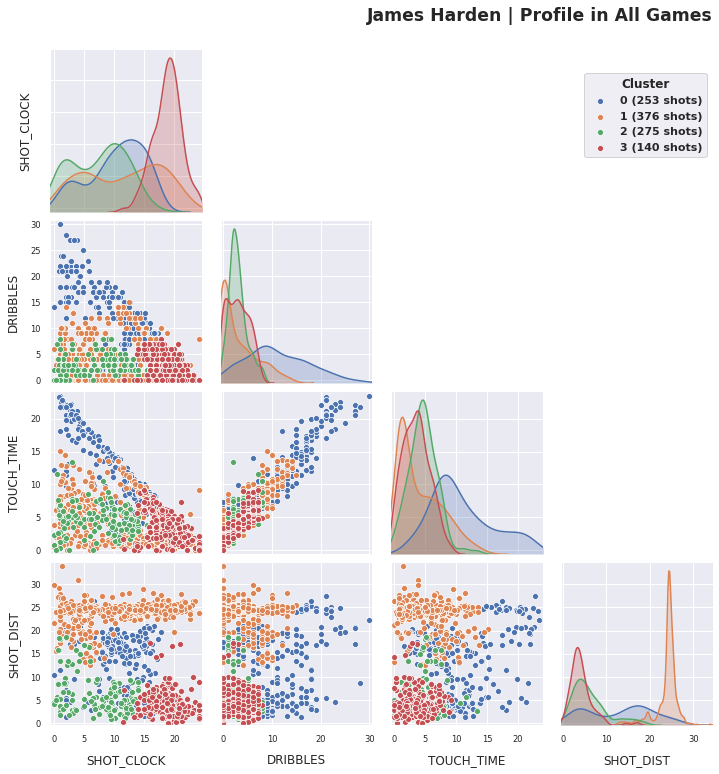

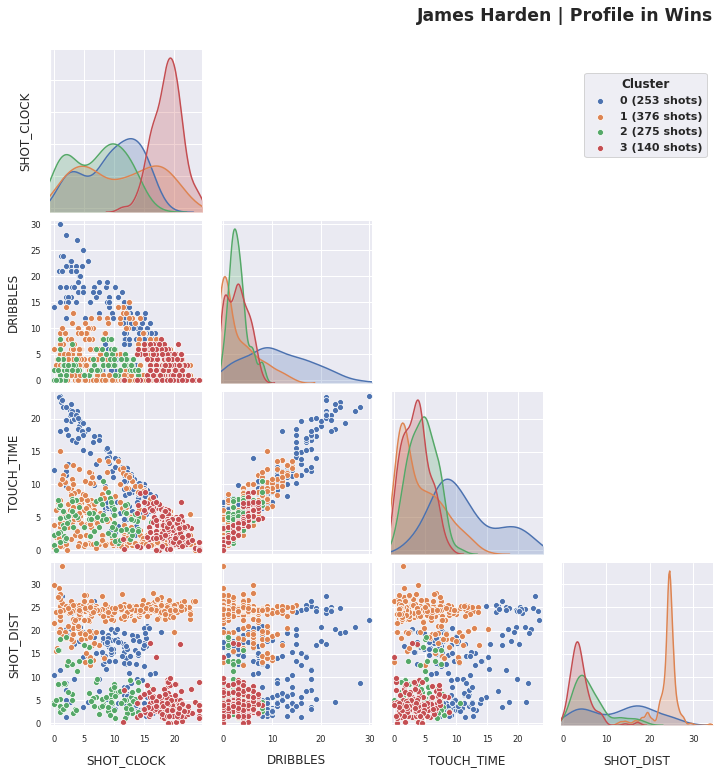

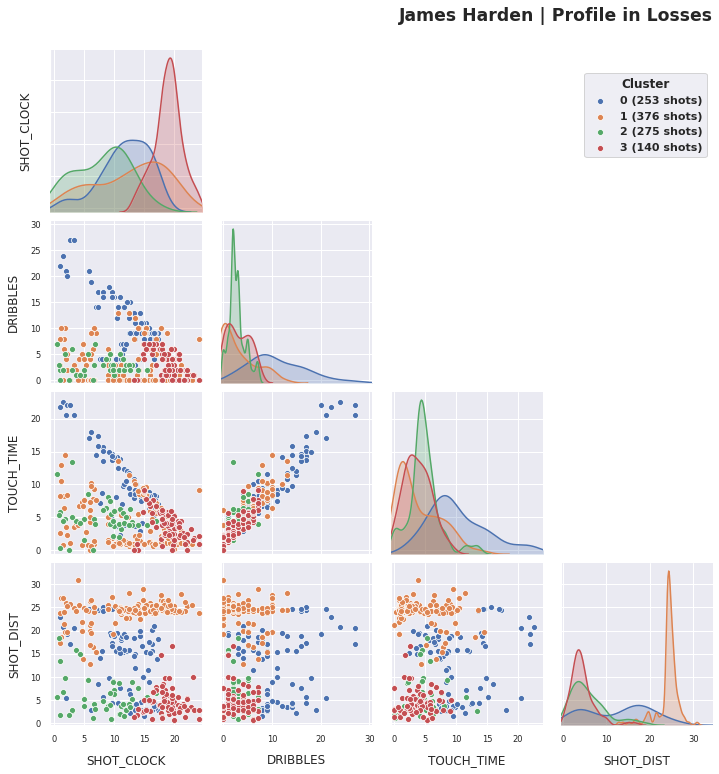

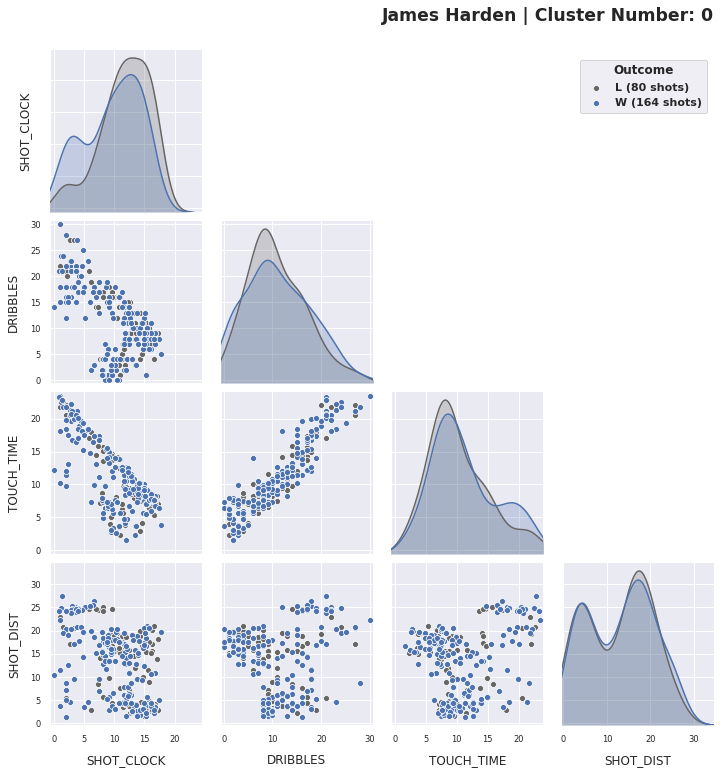

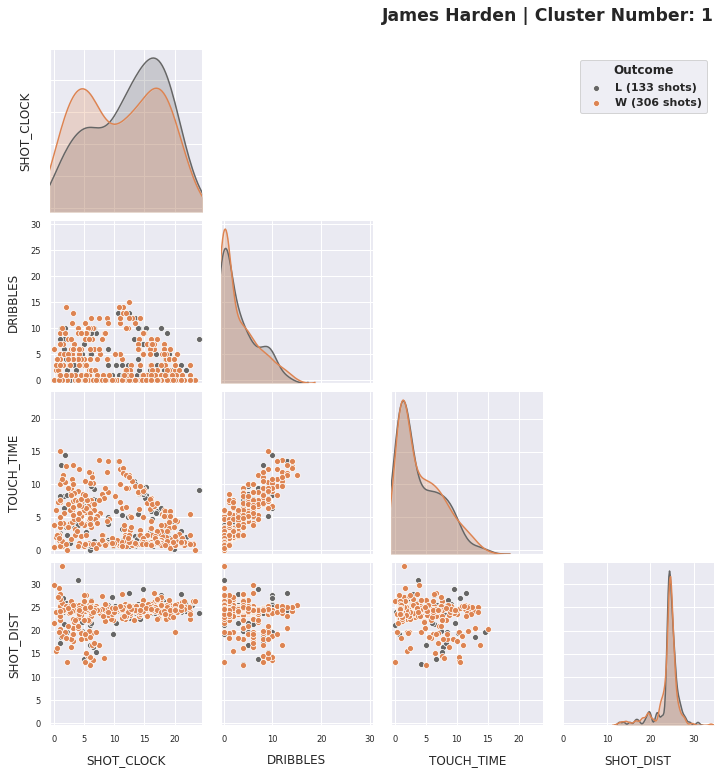

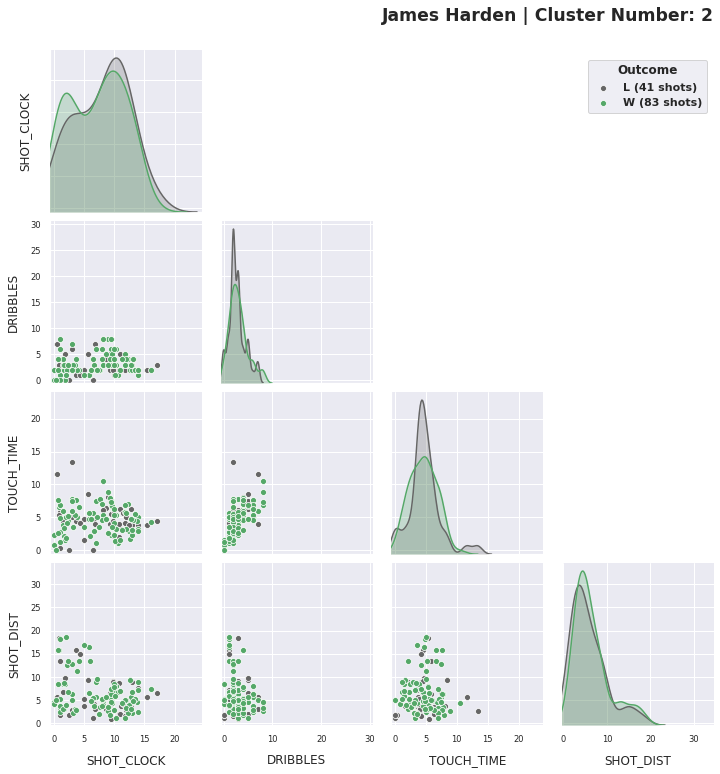

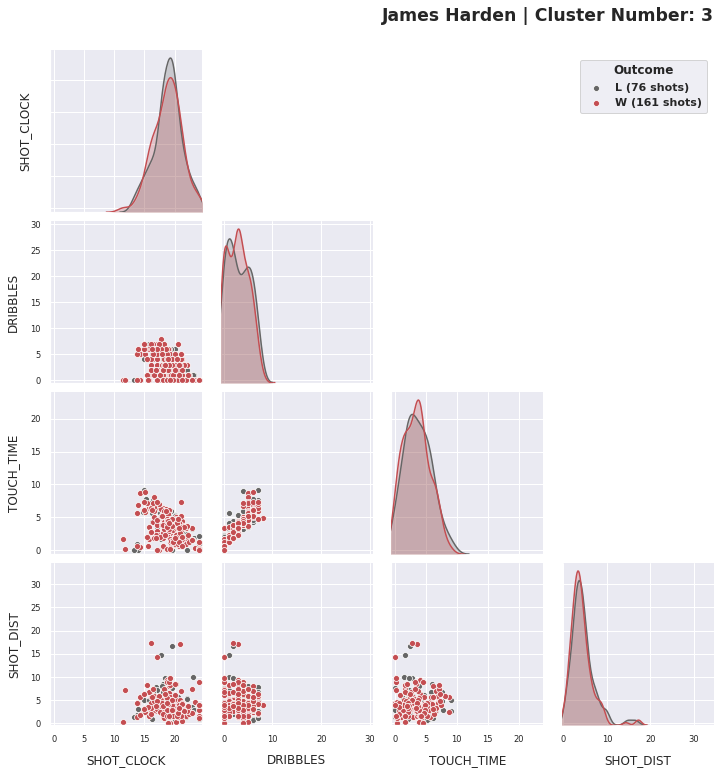

In [17]:
show_plots = True #@param {type:"boolean"}
if show_plots:
  cluster_labels = pd.Series(n2d_labels[0]).unique()
  cluster_labels.sort()

  # # This doesn't display well in Github.
  # tab_names = list(AWL_dict.keys()) + list(map(str, cluster_labels))
  # tb = widgets.TabBar(tab_names)
  # for name in AWL_dict:
  #   with tb.output_to(name):
  #     get_all_clusters_pairplot(AWL_dict[name],
  #                               cluster_vars, 
  #                               n2d_labels, 
  #                               name=name,
  #                               use_kde=use_kde)

  # for i in cluster_labels:
  #   with tb.output_to(str(i)):
  #     get_one_cluster_pairplot(pf, cluster_vars, 
  #                              n2d_labels, i=i,
  #                              use_kde=use_kde)

  print("Github doesn't render my Google Colab widget well,",
        "so I just list all of the plots here.")
  for name in AWL_dict:
    get_all_clusters_pairplot(AWL_dict[name],
                              cluster_vars, 
                              n2d_labels, 
                              name=name,
                              use_kde=use_kde)

  for i in cluster_labels:
    get_one_cluster_pairplot(pf, cluster_vars, 
                            n2d_labels, i=i,
                              use_kde=use_kde)